## Feature Crosses

###### Learning Objectives:


- Improve a linear regression model with the addition of additional synthetic features
- Use an input function to convert pandas _DataFrame_ object to _Tensors_ and invoke the input function in *fit()* and _predict()_ operations
- Use the FTRL optimization algorithm for model training
- Create new synthetic features through one-hot encoding, binning, and feature crosses

In [1]:
import math

import pandas as pd
import numpy as np
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from tensorflow.python.data import Dataset
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


In [2]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.

       Args:    california_housing_dataframe: A Pandas DataFrame expected to contain data
                from the California housing data set.
       Returns: A DataFrame that contains the features to be used for the model, including
                synthetic features.
    """
    
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (selected_features["total_rooms"] /
                                              selected_features["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.
        
       Args:    california_housing_dataframe: A Pandas DataFrame expected to contain data
                from the California housing data set.
       Returns: A DataFrame that contains the target feature.
    """
    
    selected_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
    selected_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return selected_targets
    

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples.")
display.display(training_examples.describe())
print("Validation examples.")
display.display(validation_examples.describe())

print("Training targets.")
display.display(training_targets.describe())
print("Validation targets.")
display.display(validation_targets.describe())

Training examples.


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,34.61,-118.47,27.47,2655.68,547.06,1476.01,505.38,3.80,1.94
std,1.63,1.24,12.06,2258.15,434.31,1174.28,391.72,1.85,1.33
min,32.54,-121.39,1.00,2.00,2.00,3.00,2.00,0.50,0.02
25%,33.82,-118.94,17.00,1451.75,299.00,815.00,283.00,2.52,1.42
50%,34.05,-118.21,28.00,2113.50,438.00,1207.00,411.00,3.46,1.88
75%,34.44,-117.79,36.00,3146.00,653.00,1777.00,606.00,4.64,2.26
max,41.82,-114.31,52.00,37937.00,5471.00,35682.00,5189.00,15.00,55.22


Validation examples.


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
mean,38.05,-122.18,31.28,2614.82,521.06,1318.13,491.23,4.10,2.08
std,0.92,0.48,13.39,1979.62,388.45,1073.75,366.52,2.02,0.64
min,36.14,-124.35,1.00,8.00,1.00,8.00,1.00,0.50,0.14
25%,37.49,-122.40,20.00,1481.00,292.00,731.00,278.00,2.69,1.75
50%,37.79,-122.14,31.00,2164.00,424.00,1074.00,403.00,3.73,2.07
75%,38.37,-121.91,42.00,3161.25,635.00,1590.25,603.00,5.06,2.38
max,41.95,-121.39,52.00,32627.00,6445.00,28566.00,6082.00,15.00,18.26


Training targets.


,median_house_value
count,12000.00
mean,198.04
std,111.86
min,15.00
25%,117.10
50%,170.50
75%,244.40
max,500.00


Validation targets.


,median_house_value
count,5000.00
mean,229.53
std,122.52
min,15.00
25%,130.40
50%,213.00
75%,303.15
max,500.00


In [4]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
       
       Args:    input_features: The names of the numerical input features to use.
       Returns: A set of feature columns
    """
    
    return set([tf.feature_column.numeric_column(feature) 
                for feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
       
       Args: 
           features:   pandas DataFrame of features
           targets:    pandas DataFrame of targets
           batch_size: Size of batches to be passed to the model
           shuffle:    True or False. Whether to shuffle the data.
           num_epochs: Number of epochs for which data should be repeated.
                       None = repeat indefinitely
       Returns:        
           Tuple of (features, labels) for next data batch
    """
    
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### FTRL Optimization Algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [6]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.
       In addition to training, this function also prints training progress information,
        as well as a plot of the training and validation loss over time.
  
      Args:
          learning_rate: A `float`, the learning rate.
          steps: A non-zero `int`, the total number of training steps. A training step
                 consists of a forward and backward pass using a single batch.
          feature_columns: A `set` specifying the input feature columns to use.
          training_examples: A `DataFrame` containing one or more columns from
                             `california_housing_dataframe` to use as input features for training.
          training_targets: A `DataFrame` containing exactly one column from
                            `california_housing_dataframe` to use as target for training.
          validation_examples: A `DataFrame` containing one or more columns from
                               `california_housing_dataframe` to use as input features for validation.
          validation_targets: A `DataFrame` containing exactly one column from
                              `california_housing_dataframe` to use as target for validation.

    Returns:
          A `LinearRegressor` object trained on the training data.
    """
    
    #set number of periods
    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
    )

    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(input_fn=training_input_fn,
                               steps=steps_per_period)
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")


    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 153.45
  period 01 : 152.46
  period 02 : 148.68
  period 03 : 147.36
  period 04 : 146.04
  period 05 : 144.59
  period 06 : 144.66
  period 07 : 142.71
  period 08 : 143.28
  period 09 : 141.60
Model training finished.


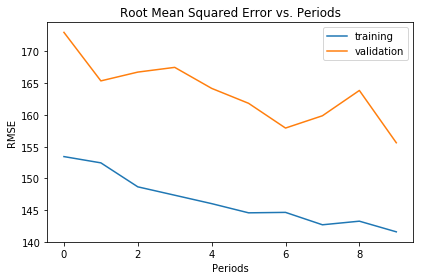

In [7]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [8]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longiture = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

### Task 1: Train the Model on Bucketized Feature Columns

In [16]:
def construct_feature_columns1(training_examples):
    """Construct the TensorFlow Feature Columns.
    
       Returns:A set of feature columns
    """ 
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
    # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
          training_examples["households"], 7))

    # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
          training_examples["longitude"], 10))

    #
    # 1.YOUR CODE HERE: bucketize the following columns, following the example above:
    #
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
            training_examples["latitude"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
            training_examples["housing_median_age"], 7))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
            training_examples["median_income"], 7))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
            training_examples["rooms_per_person"] ,7))
    
    # 2.YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
    long_x_lat = tf.feature_column.crossed_column([bucketized_longitude,
                                                   bucketized_latitude],
                                                  1000)

    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person,
        long_x_lat])

    return feature_columns

Training model...
RMSE (on training data):
  period 00 : 169.52
  period 01 : 146.73
  period 02 : 131.42
  period 03 : 120.73
  period 04 : 113.77
  period 05 : 108.92
  period 06 : 105.05
  period 07 : 101.37
  period 08 : 98.21
  period 09 : 95.82
Model training finished.


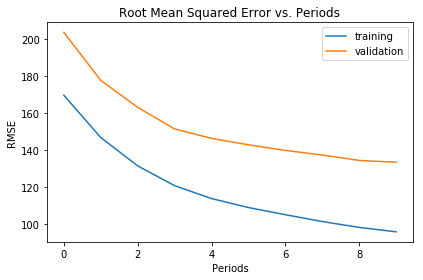

In [17]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns1(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Optional Challenge: Try Out More Synthetic Features

So far, we've tried simple bucketized columns and feature crosses, but there are many more combinations that could potentially improve the results. For example, you could cross multiple columns. What happens if you vary the number of buckets? What other synthetic features can you think of? Do they improve the model?